In [1]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

Train model on wind and energy data at once

In [ ]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

columns_to_add = list()

for col in merged_hornsea.columns:
    if col not in merged_pes.columns:
        columns_to_add.append(col)

merged_all = merged_pes.merge(merged_hornsea[columns_to_add], left_index = True, right_index = True)
merged_all["energy"] = merged_all["Solar_MWh_credit"] + merged_all["Wind_MWh_credit"]
merged_all.drop(["Solar_MWh_credit", "Wind_MWh_credit"], axis = 1, inplace = True)

from Preprocessing import *
feature_engineerer_all = FeatureEngineerer(labels_to_remove=  ["energy"], columns_to_ohe = ['unavailabilityType', 'affectedUnit'], label = ["energy"])
feature_engineerer_all.perform_feature_engineering(merged_all, deployment = False, labels_to_remove=  ["energy"])

import numpy as np
quantiles = np.arange(0.1, 1.0, 0.1).round(2)

# Specify model save directory
model_save_dir_qr = "lgbm_mode"

lgbm_model = model_utils.LGBMRegressorModel(feature_engineerer_all, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model.train_and_predict()  # This will skip training for already loaded models

def pinball_score(self):
        """pinball score implemetation"""

        score = []
        try:
            df = pd.DataFrame(self.q_predictions)
        except:
            df = pd.DataFrame()
            for k in self.q_predictions.keys():
                df[k] = pd.DataFrame(self.q_predictions[k])
        for qu in self.quantiles:
            score.append(self.pinball(y=df["true"], q=df[str(qu)], alpha=qu).mean())
        return sum(score) / len(score)

print(pinball_score(lgbm_model))
# import plotly.express as px
# df.index = feature_engineerer_all.y_test.index
# px.line(df, y = ["true", "0.5"])

In [1]:
from Preprocessing import * 

prep = Preprocessing()

merged_hornsea = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_hornsea":"nc_files", "ncep_gfs_hornsea":"nc_files"},
                                              deployment = False, merge_with_outage_data = True, json_file_path = "nc_files/REMIT", energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False,
                                              #columns_to_fft = ["temp_diff", "solar_down_rad_diff", "wind_dir_sin", "wind_dir_cos", "wind_dir_100_sin", "wind_dir_100_cos"]
                                              )

merged_pes = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_pes":"nc_files", "ncep_gfs_pes":"nc_files"},
          deployment = False, merge_with_outage_data = False, energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, ) 

merged_demand = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_demand":"nc_files", "ncep_gfs_demand":"nc_files"},
          deployment = False, merge_with_outage_data = True, energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

INFO:root:Perform data cleaning on the weather data...
INFO:root:Merge weather stations...
INFO:root:Merge with outages data (REMIT)...
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:328: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  outages_df = pd.concat([outages_df, json_data_with_date_ranges])
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:328: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outages_df = pd.concat([outages_df, json_data_with_date_ranges])
INFO:root:Merge with energy data...
INFO:root:Pr

In [7]:
merged_hornsea.to_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes.to_parquet("preprocessed_pes_with_energy.parquet")
merged_demand.to_parquet("preprocessed_demand_with_energy.parquet")

In [2]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

### __Wind Energy Forecast__

__baseline__

In [ ]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1).round(2)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

In [ ]:
qr_model_wind.plot_quantils(feature_engineerer_wind_baseline.y_test.index, qr_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023)

__xgboost__

In [ ]:
importlib.reload(model_utils)
import numpy as np

quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_wind"
hyperparams = {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": quantiles,
            "learning_rate": 0.01,
            "max_depth": 8
        }

xgboost_model_wind = model_utils.XGBoostModel(feature_engineerer_wind, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False, hyperparams=hyperparams, num_boost_round=45, early_stopping_rounds=10)
xgboost_model_wind.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_wind.pinball_score()}")

In [ ]:
xgboost_model_wind.plot_feature_importance()

In [ ]:
xgboost_model_wind.plot_quantils(daterange=feature_engineerer_wind.y_test.index, y=xgboost_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023)

### __Solar Energy Forecast__

__baseline modell__

In [ ]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

In [ ]:
qr_model_solar.plot_quantils(daterange=feature_engineerer_solar_baseline.y_test.index, y=qr_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023)

__xgboost__

In [ ]:
quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_solar"

xgboost_model_solar = model_utils.XGBoostModel(feature_engineerer_solar, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False)
xgboost_model_solar.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_solar.pinball_score()}")

In [ ]:
xgboost_model_solar.plot_feature_importance()

In [ ]:
xgboost_model_solar.plot_quantils(daterange=feature_engineerer_solar.y_test.index, y=xgboost_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023, month = 7, day = 10)

### __Lightgbm implementation__

In [14]:
importlib.reload(model_utils)
import numpy as np
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind.pinball_score()}")

[LightGBM] [Info] Total Bins 14479
[LightGBM] [Info] Number of data points in the train set: 39984, number of used features: 74
[LightGBM] [Info] Start training from score 9.086801
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 10.1207	valid's quantile: 10.9699
[100]	train's quantile: 9.33063	valid's quantile: 10.9081
Early stopping, best iteration is:
[78]	train's quantile: 9.49369	valid's quantile: 10.8761
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_wind\lgbm_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 14479
[LightGBM] [Info] Number of data points in the train set: 39984, number of used features: 74
[LightGBM] [Info] Start training from score 43.821404
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 14.4102	valid's quantile: 17.3024
[100]	train's quantile: 13.4749	valid's quantile: 17.2526
Early stopping, best iteration is:
[75]	train's quantile: 13.8839	valid's quantile: 17.2107
Saved 

In [20]:
importlib.reload(model_utils)
import numpy as np
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind_hp"

for q in np.arange(0.1, 1.0, 0.1).round(2):
    params = {
                    "alpha":[q],
                    'boosting': ["gbdt", "dart"],
                    "force_col_wise": [True],
                    "num_leaves": [20, 40],
                    "max_depth": [3, 5, 10],
                    'learning_rate': [0.001, 0.01, 0.1],
                    "n_estimators": [250, 500],
                    'objective': ['quantile'],
                    "min_data_in_leaf":[200, 300, 500],
                    "random_state": [42],
                    "verbose":[-1],
                    "extra_trees":[False],
                }
    lgbm_model_wind_hp = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles = [q], model_save_dir=model_save_dir_qr, load_pretrained=False)
    lgbm_model_wind_hp.train_and_predict_hyperparametertuning(parameters=params)  # This will skip training for already loaded models
    print(f"Quantile Regressor Pinball Score: {lgbm_model_wind_hp.pinball_score()}")

--------Train model for Quantile 0.1: 


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [ ]:
lgbm_model_wind.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind.q_predictions, quantiles, year = 2023, month=7)

In [ ]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar"

lgbm_model_solar = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar.pinball_score()}")

In [ ]:
lgbm_model_solar.plot_quantils(feature_engineerer_solar.y_test.index, lgbm_model_solar.q_predictions, quantiles, year=2023, month=6, day=19)

### LSTM

In [4]:
import torch.nn
import neural_networks
from neural_networks import *

import Preprocessing

import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

class LSTM_model(neural_networks.q_model):
    def __init__(self, quantiles= np.arange(0.1, 1.0, 0.1).round(2), 
                 in_shape=50,  
                 dropout=0.5,
                 len_features=66):
        super().__init__(quantiles = quantiles, in_shape = in_shape, dropout = dropout, len_features = len_features)

    def build_model(self):

        self.lstm1 = nn.LSTM(self.len_features, 20, dropout=0.3,  num_layers = 2, batch_first=True)
        self.activation = nn.ReLU()
        # Final layers for quantiles
        final_layers = [
            nn.Linear(20, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)

    def forward(self, x):
        # x is of shape (batch_size, seq_len, len_features)
        # LSTM layers - extracting the output (not hidden and cell states)
        out, _ = self.lstm1(x)
        # Apply final layers to get quantile outputs
        quantile_outputs = [layer(out) for layer in self.final_layers]
        
        return torch.cat(quantile_outputs, dim=-1)
    
    def init_weights(self): 
        for m in chain(self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)   

quantiles = np.arange(0.1, 1.0, 0.1)

lstm_wind = neural_networks.Trainer(feature_engineerer_wind,  LSTM_model,quantiles, lr = 0.01, batch_size = 32)
lstm_wind.train_and_test()

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 736.8152465820312
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 402.4713439941406
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 205.65716552734375
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 152.38055419921875
40. epoche startet: 
41. epoche startet: 
42. epoche sta

AttributeError: module 'model_utils' has no attribute 'pinball_score_nn'

In [7]:
def save_pytorch_model(model, model_name):
    torch.save(model.state_dict(), f"{model_name}")

def load_pytorch_model(class_name, model_name, len_features, quantiles = np.arange(0.1, 1.0, 0.1).round(2)):
    model = class_name(quantiles = quantiles, len_features = len_features)
    model.load_state_dict(torch.load(f"{model_name}", weights_only=True))

save_pytorch_model(lstm_wind.model, "LSTM_wind")
load_pytorch_model(LSTM_model, "LSTM_wind", feature_engineerer_wind.X_train.shape[1])

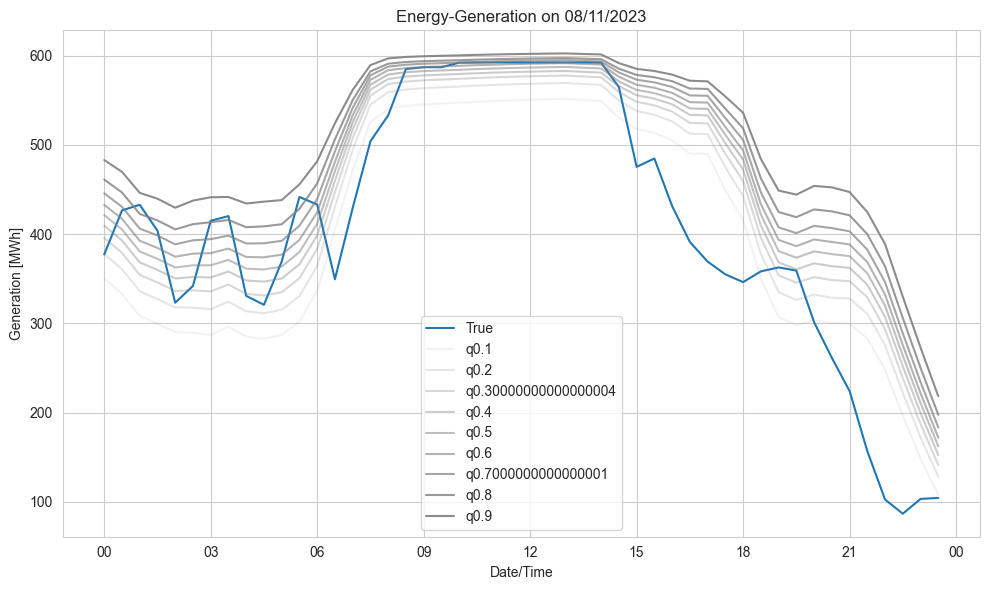

In [8]:
lstm_wind.plot_quantils(feature_engineerer_wind.y_test.index, nn_wind.q_prediction_nn, quantiles, year = 2023, month = 11, day = 8)

In [10]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)

import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

import neural_networks
import numpy as np
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn
quantiles = np.arange(0.1, 1.0, 0.1)

nn_wind = neural_networks.Trainer(feature_engineerer_wind, neural_networks.q_model,quantiles)
nn_wind.train_and_test()

c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 


KeyboardInterrupt: 

In [ ]:
import neural_networks
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn
quantiles = np.arange(0.1, 1.0, 0.1)

nn_solar = neural_networks.Trainer(feature_engineerer_solar, neural_networks.q_model, quantiles, in_shape=30)
nn_solar.train_and_test()

In [ ]:
nn_solar.plot_quantils(feature_engineerer_solar.y_test.index, nn_solar.q_prediction_nn, quantiles, day=8)

In [1]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)

import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

In [48]:
from neural_networks import *
# source: https://github.com/TheQuantScientist/CNN-LSTM-AM/blob/main/src/CLAM.ipynb
cnn_lstm = CNN_LSTM(feature_engineerer = feature_engineerer_wind, forecast_length = 1, sequence_length = 1)
cnn_lstm.fit_models(model_name = "CNN_LSTM_wind", model_save_dir = "CNN_LSTM", verbose = 0, batch_size = 64, epochs = 20, lr = 0.01)

# Evaluate the model


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:root:Saved model at CNN_LSTM/CNN_LSTM_wind_quantile_0.1.h5
INFO:root:Saved model at CNN_LSTM/CNN_LSTM_wind_quantile_0.2.h5
INFO:root:Saved model at CNN_LSTM/CNN_LSTM_wind_quantile_0.3.h5
INFO:root:Saved model at CNN_LSTM/CNN_LSTM_wind_quantile_0.4.h5
INFO:root:Saved model at CNN_LSTM/CNN_LSTM_wind_quantile_0.5.h5
INFO:root:Saved model at CNN_LSTM/CNN_LSTM_wind_quantile_0.6.h5
INFO:root:Saved model at CNN_LSTM/CNN_LSTM_wind_quantile_0.7.h5
INFO:root:Saved model at CNN_LSTM/CNN_LSTM_wind_quantile_0.8.h5
INFO:root:Saved model at CNN_LSTM/CNN_LSTM_wind_quantile_0.9.h5


In [50]:
import numpy as np
import tensorflow as tf
pred_and_true = pd.DataFrame(index = feature_engineerer_wind.y_test.index)

for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    q = np.round(q, 1)
    m = tf.keras.saving.load_model(f"CNN_LSTM/CNN_LSTM_wind_quantile_{q}.h5", compile = False)
    pred = m.predict(feature_engineerer_wind.X_test.reshape(-1, 1, 74))[:, 0]
    if len(pred.shape) > 2:
        pred = pred[:, 0]
    pred_and_true[str(q)] = pred

pred_and_true["true"] = feature_engineerer_wind.y_test

276/276 [==============================] - 1s 3ms/step


In [22]:
lstm_wind
cnn_lstm
lgbm_model_wind

In [28]:
lgbm_model_wind.q_predictions

{'true': array([518.961, 508.881, 464.601, ..., 572.64 , 586.32 , 561.23 ]),
 '0.1': array([388.81927786, 388.81927786, 388.81927786, ..., 537.54895822,
        537.54895822, 534.05666448]),
 '0.2': array([442.06764015, 442.06764015, 442.06764015, ..., 545.54072958,
        546.8585975 , 535.23135793]),
 '0.30000000000000004': array([484.00692374, 480.36361957, 477.71923331, ..., 547.48388817,
        547.26982877, 539.9157227 ]),
 '0.4': array([489.65875049, 485.47079611, 482.68167252, ..., 562.65565004,
        563.22193938, 546.59927227]),
 '0.5': array([522.56853087, 515.14086186, 515.81784961, ..., 563.82694455,
        563.82694455, 546.90964822]),
 '0.6': array([530.65119928, 519.62471073, 523.07521518, ..., 576.22937492,
        576.22937492, 547.1586383 ]),
 '0.7000000000000001': array([531.6335789 , 532.89923082, 530.69009051, ..., 584.13009735,
        584.27922861, 547.35870132]),
 '0.8': array([550.92914422, 545.16196705, 539.7242367 , ..., 585.82304132,
        585.823041

In [98]:
def pinball_score_single(df, qu):
        score = model_utils.pinball(y=df["true"],
                                q=df[f"{qu}"],
                                alpha=qu).mean()
        return score

all_scores = dict()
all_scores["CNN_LSTM"] = dict()
all_scores["LSTM"] = dict()
all_scores["LGBM"] = dict()
for q in np.arange(0.1, 1.0, 0.1).round(2):
        all_scores["CNN_LSTM"][q] = pred_and_true[str(q)].values
        all_scores["LSTM"][q] = q_predictions_lstm[str(q)]
        all_scores["LGBM"][q] = lgbm_model_wind.q_predictions[str(q)]
all_scores["index"] = feature_engineerer_wind.y_test.index
all_scores["True"] = feature_engineerer_wind.y_test.values

In [104]:
all_scores

{'CNN_LSTM': {0.1: array([475.15454, 469.2442 , 466.67523, ..., 513.996  , 514.0033 ,
         513.9996 ], dtype=float32),
  0.2: array([487.73196, 481.08563, 478.0553 , ..., 529.72815, 529.7328 ,
         529.73065], dtype=float32),
  0.3: array([481.38348, 476.5226 , 473.64413, ..., 540.9611 , 540.99994,
         541.03937], dtype=float32),
  0.4: array([159.2236, 159.2236, 159.2236, ..., 159.2236, 159.2236, 159.2236],
        dtype=float32),
  0.5: array([234.85536, 234.85536, 234.85536, ..., 234.85536, 234.85536,
         234.85536], dtype=float32),
  0.6: array([319.8213, 319.8213, 319.8213, ..., 319.8213, 319.8213, 319.8213],
        dtype=float32),
  0.7: array([449.72418, 449.72418, 449.72418, ..., 449.72418, 449.72418,
         449.72418], dtype=float32),
  0.8: array([542.7942, 542.7942, 542.7942, ..., 542.7942, 542.7942, 542.7942],
        dtype=float32),
  0.9: array([573.11176, 573.11176, 573.11176, ..., 573.11176, 573.11176,
         573.11176], dtype=float32)},
 'LSTM': 

In [89]:
pd.DataFrame(pred_lstm)

,0,1,2,3,4,5,6,7,8
0,420.198944,434.431793,441.279510,445.578461,449.531158,453.286804,456.331177,459.124023,465.106812
1,503.134125,521.390076,530.471924,536.236511,541.446899,546.322510,550.470459,554.222107,561.269348
2,504.611420,523.700439,533.403809,539.575684,545.181152,550.439514,555.009827,559.347473,567.119385
3,499.725372,519.145203,529.189270,535.566589,541.402100,546.887268,551.680298,556.419861,564.639038
4,497.967133,517.469666,527.596130,534.003113,539.878784,545.407410,550.230347,555.079712,563.247375
...,...,...,...,...,...,...,...,...,...
8827,549.630554,567.620667,576.083557,581.317261,585.916321,590.258362,593.671753,596.177124,601.499817
8828,549.960571,567.927673,576.371643,581.583984,586.169434,590.496277,593.886047,596.362061,601.669250
8829,550.263245,568.209290,576.635925,581.828613,586.401611,590.714661,594.082642,596.531616,601.824829
8830,550.556396,568.481995,576.891907,582.065552,586.626465,590.926086,594.272949,596.695801,601.975525


In [100]:
import pickle 
with open('all_scores.pickle', 'wb') as handle:
    pickle.dump(all_scores, handle)

with open('all_scores.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [97]:
q_predictions_lstm = dict()
pred_lstm = pd.DataFrame(lstm_wind.predict(feature_engineerer_wind.X_test), columns = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"])
i = 0
for q in np.arange(0.1, 1.0, 0.1).round(2): 
    q_predictions_lstm[str(q)] = pred_lstm.loc[:, str(q)]
    i += 1

In [56]:
cnn_lstm_q_predictions = dict()
for col in pred_and_true.columns:
    cnn_lstm_q_predictions[col] = pred_and_true[col].values
cnn_lstm_q_predictions

{'0.1': array([475.15454, 469.2442 , 466.67523, ..., 513.996  , 514.0033 ,
        513.9996 ], dtype=float32),
 '0.2': array([487.73196, 481.08563, 478.0553 , ..., 529.72815, 529.7328 ,
        529.73065], dtype=float32),
 '0.3': array([481.38348, 476.5226 , 473.64413, ..., 540.9611 , 540.99994,
        541.03937], dtype=float32),
 '0.4': array([159.2236, 159.2236, 159.2236, ..., 159.2236, 159.2236, 159.2236],
       dtype=float32),
 '0.5': array([234.85536, 234.85536, 234.85536, ..., 234.85536, 234.85536,
        234.85536], dtype=float32),
 '0.6': array([319.8213, 319.8213, 319.8213, ..., 319.8213, 319.8213, 319.8213],
       dtype=float32),
 '0.7': array([449.72418, 449.72418, 449.72418, ..., 449.72418, 449.72418,
        449.72418], dtype=float32),
 '0.8': array([542.7942, 542.7942, 542.7942, ..., 542.7942, 542.7942, 542.7942],
       dtype=float32),
 '0.9': array([573.11176, 573.11176, 573.11176, ..., 573.11176, 573.11176,
        573.11176], dtype=float32),
 'true': array([518.96

In [ ]:
import matplotlib.pyplot as plt
from model_utils import *

def plot_quantile_performance(model_list, model_names, title, quantiles):
        # Dictionary, um Scores für alle Modelle zu speichern
        quantile_scores = {qu: [] for qu in quantiles}

        for model in model_list:
            # Flatten the predictions
            model.q_predictions = {k: v.flatten() for k, v in model.q_predictions.items() if k != "date"}
            df = pd.DataFrame(model.q_predictions)

            # Berechnung der Pinball-Scores für jedes Quantil
            for qu in quantiles:
                score = pinball(y=df["true"], q=df[str(qu)], alpha=qu).mean()
                quantile_scores[qu].append(score)  # Score zum entsprechenden Quantil hinzufügen

        
        num_models = len(model_list)
        bar_width = 0.15  
        index = np.arange(len(quantiles))

        
        for i, model_scores in enumerate(zip(*quantile_scores.values())):
            plt.bar(index + i * bar_width, model_scores, bar_width, label=model_names[i])

        plt.xlabel('Quantile')
        plt.ylabel('Pinball Score')
        plt.title(title)
        plt.xticks(index + bar_width * (num_models - 1) / 2, quantiles)  
        plt.legend(title='Models')
        plt.tight_layout()
        plt.show()

In [41]:
def pinball_score_nn_single(df, qu):
    score = model_utils.pinball(y=df["true"],
                             q=df[f"{qu}"],
                             alpha=qu).mean()
    return score

for q in np.arange(0.1, 1.0, 0.1).round(2):
    print(f"{q}", pinball_score_nn_single(pred_and_true, q))

0.1 16.480266091743356
0.2 22.67739289563589
0.3 25.71482632737239
0.4 94.25536372278148
0.5 28.203032268615285
0.6 99.92014306225897
0.7 22.470353653565816
0.8 17.467326247247
0.9 12.257708329632818


In [169]:
model_utils.pinball_score_nn(pred_and_true, quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

37.71626806653922

In [185]:
import plotly.express as px

px.line(pred_and_true, y = ["true", "0.5", "0.1", "0.9"])